In [37]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv("/content/infosys_data.csv")
df.head()

,rating,title,location,role,date,pros,cons
0,4.0,Good and Stable Company,"Current employee, more than 8 years",Techincal lead,23 Oct 2024,Wonderful Infrastructure\nGood at Job Security,Low salary\nLesser growth opportunity
1,3.0,Infosys by associate BA,"Current employee, more than 3 years",Associate business analyst,23 Oct 2024,1. Training\n\n2. Infrastructure\n\n3. Great C...,"Work-Life Balance:\n- Like many IT companies, ..."
2,4.0,eee,Current employee,Systems engineer,23 Oct 2024,good training\ngood campus\ngood trees,bad manager\nregional bias in every office
3,5.0,Infosys Limited,Current employee,Technology analyst,23 Oct 2024,Very good policy structure managed.,Employee hikes per financial year.
4,2.0,Stagnant Career Growth and Low Pay,"Current employee, more than 3 years",Senor software engineer,23 Oct 2024,working in Infosys has only 1 benefit that you...,1. No hike.\n2. HR never replies to your quest...


In [3]:
# Calculate key metrics
avg_rating = df['rating'].mean()
rating_distribution = df['rating'].value_counts(normalize=True) * 100
sentiment_trend = df.groupby(pd.to_datetime(df['date']).dt.to_period('M'))['rating'].mean()

In [4]:
avg_rating

np.float64(3.6)

In [5]:
rating_distribution

,proportion
rating,
4.0,50.0
3.0,30.0
5.0,10.0
2.0,10.0


In [6]:
sentiment_trend

,rating
date,
2024-10,3.6


In [7]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Analyze pros
pros_text = ' '.join(df['pros'].dropna())
vectorizer = CountVectorizer(stop_words='english', max_features=100)
pros_matrix = vectorizer.fit_transform(df['pros'].dropna())
lda = LatentDirichletAllocation(n_components=5)
lda.fit(pros_matrix)

LatentDirichletAllocation(n_components=5)

In [8]:
role_analysis = df.groupby('role').agg({
    'rating': ['mean', 'count'],
    'location': 'nunique'
}).round(2)

# Top roles by satisfaction
top_roles = df.groupby('role')['rating'].mean().sort_values(ascending=False)

In [9]:
top_roles

,rating
role,
Technology analyst,4.5
Anonymous employee,4.0
Qa engineer,4.0
Systems engineer,4.0
Techincal lead,4.0
Associate business analyst,3.0
Senior associate lead,3.0
Technology lead (us),3.0
Senor software engineer,2.0


**Counting mentions of Key Issues**

In [29]:
salary_mentions = df['cons'].str.contains('salary|pay|hike', case=False, na=False).sum()
salary_mentions

np.int64(150)

In [30]:
growth_mentions = df['cons'].str.contains('growth|opportunity|career', case=False, na=False).sum()
growth_mentions

np.int64(60)

In [31]:
worklife_mentions = df['cons'].str.contains('work.life|balance|hours', case=False, na=False).sum()
worklife_mentions

np.int64(30)

In [32]:
management_mentions = df['cons'].str.contains('manager|management|HR', case=False, na=False).sum()
management_mentions

np.int64(60)

**Monthly Trend**

In [33]:
df['date_parsed'] = pd.to_datetime(df['date'], errors='coerce')
monthly_trend = df.groupby(df['date_parsed'].dt.to_period('M'))['rating'].agg(['mean', 'count'])

In [34]:
monthly_trend

,mean,count
date_parsed,,
2024-10,3.6,300


**Sentiment Analysis**

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob
from wordcloud import WordCloud
import re
from collections import Counter

# Setup plotting
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)

In [35]:
# Assuming your dataframe is called 'df'
# Clean the text data
df['pros_clean'] = df['pros'].fillna('').apply(lambda x: re.sub(r'\n+', ' ', str(x)))
df['cons_clean'] = df['cons'].fillna('').apply(lambda x: re.sub(r'\n+', ' ', str(x)))

# Extract tenure from location column
def extract_tenure(text):
    text = str(text).lower()
    if 'more than 8 years' in text: return '8+ years'
    elif 'more than 3 years' in text: return '3-8 years'
    elif 'more than 1 year' in text: return '1-3 years'
    else: return 'Less than 1 year'

df['tenure'] = df['location'].apply(extract_tenure)

print("Data cleaned successfully")
print(f"Total reviews: {len(df)}")

Data cleaned successfully
Total reviews: 300


In [19]:
# Calculate sentiment for pros
df['pros_sentiment'] = df['pros_clean'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)
df['pros_subjectivity'] = df['pros_clean'].apply(lambda x: TextBlob(str(x)).sentiment.subjectivity)

# Calculate sentiment for cons
df['cons_sentiment'] = df['cons_clean'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)
df['cons_subjectivity'] = df['cons_clean'].apply(lambda x: TextBlob(str(x)).sentiment.subjectivity)

# Create overall sentiment score (weighted average)
df['overall_sentiment'] = (df['pros_sentiment'] * 0.7 + df['cons_sentiment'] * 0.3)

print("Sentiment scores calculated!")
print(f"Average Pros Sentiment: {df['pros_sentiment'].mean():.3f}")
print(f"Average Cons Sentiment: {df['cons_sentiment'].mean():.3f}")

Sentiment scores calculated!
Average Pros Sentiment: 0.636
Average Cons Sentiment: -0.154


In [20]:
# Display sentiment statistics
sentiment_stats = pd.DataFrame({
    'Pros_Sentiment': df['pros_sentiment'].describe(),
    'Cons_Sentiment': df['cons_sentiment'].describe(),
    'Overall_Sentiment': df['overall_sentiment'].describe()
})

print("SENTIMENT STATISTICS:")
print(sentiment_stats)

# Categorize sentiments
def sentiment_category(score):
    if score > 0.1: return 'Positive'
    elif score < -0.1: return 'Negative'
    else: return 'Neutral'

df['pros_sentiment_category'] = df['pros_sentiment'].apply(sentiment_category)
df['cons_sentiment_category'] = df['cons_sentiment'].apply(sentiment_category)

print("\nSENTIMENT DISTRIBUTION:")
print("Pros Sentiment Categories:")
print(df['pros_sentiment_category'].value_counts())
print("\nCons Sentiment Categories:")
print(df['cons_sentiment_category'].value_counts())

SENTIMENT STATISTICS:
       Pros_Sentiment  Cons_Sentiment  Overall_Sentiment
count      300.000000      300.000000         300.000000
mean         0.636000       -0.154414           0.398876
std          0.255503        0.239169           0.217076
min          0.000000       -0.700000          -0.065000
25%          0.650000       -0.216667           0.280000
50%          0.700000        0.000000           0.490000
75%          0.800000        0.000000           0.565507
max          0.910000        0.018358           0.637000

SENTIMENT DISTRIBUTION:
Pros Sentiment Categories:
pros_sentiment_category
Positive    270
Neutral      30
Name: count, dtype: int64

Cons Sentiment Categories:
cons_sentiment_category
Neutral     180
Negative    120
Name: count, dtype: int64


**Semtiment Distribution**

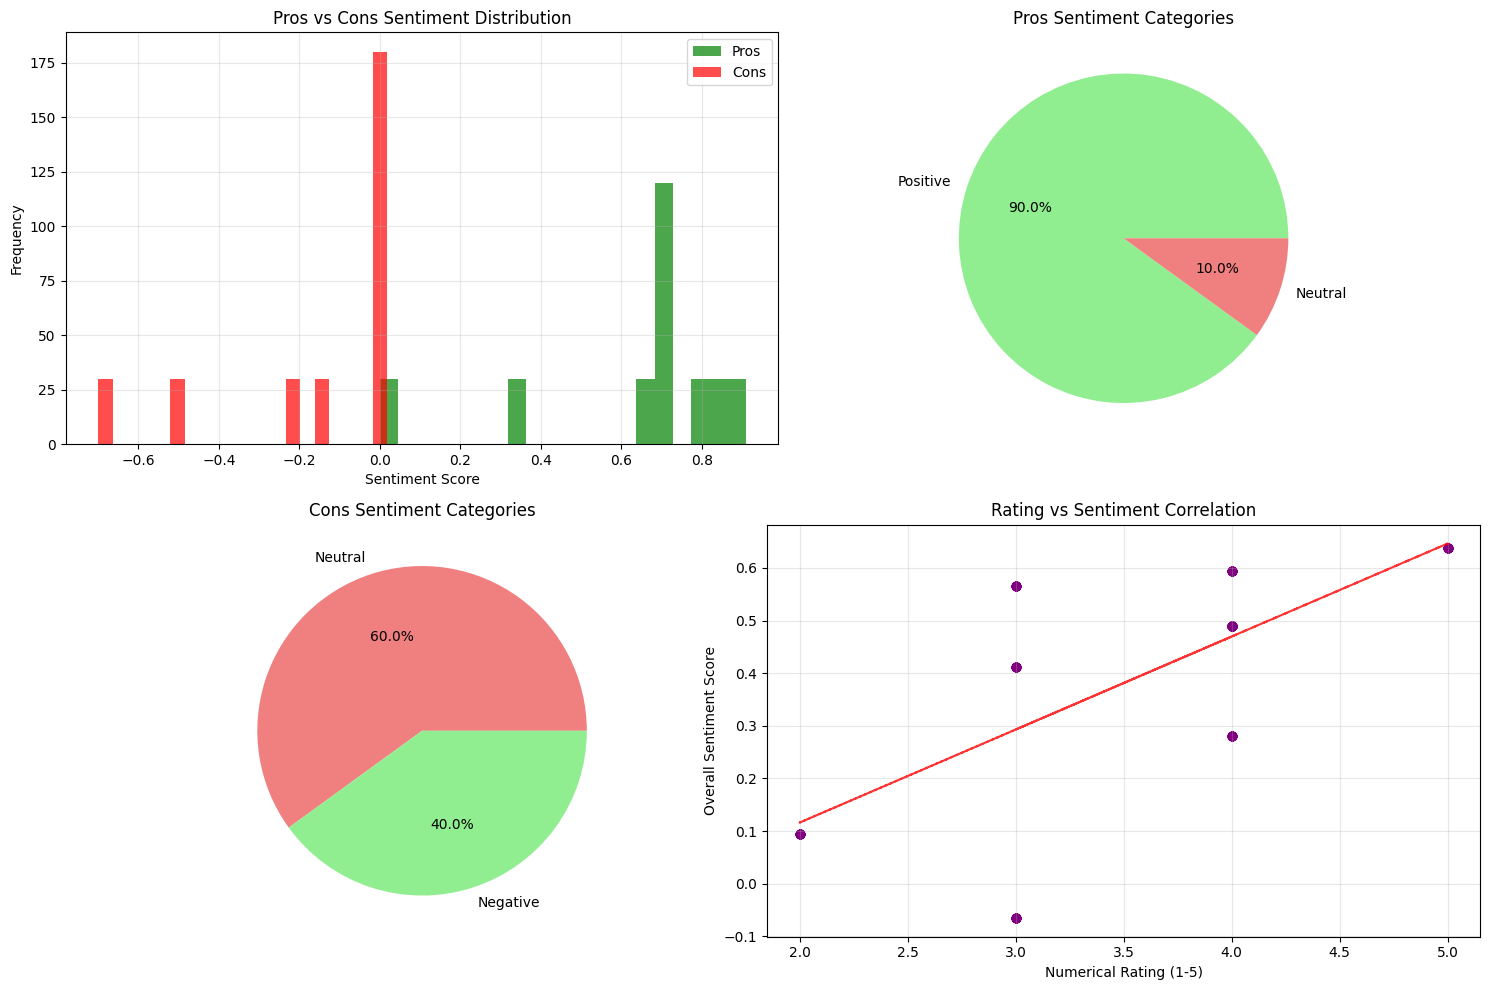

Correlation between rating and sentiment: 0.652


In [21]:
# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: Pros vs Cons sentiment distribution
axes[0,0].hist(df['pros_sentiment'], alpha=0.7, label='Pros', bins=20, color='green')
axes[0,0].hist(df['cons_sentiment'], alpha=0.7, label='Cons', bins=20, color='red')
axes[0,0].set_title('Pros vs Cons Sentiment Distribution')
axes[0,0].set_xlabel('Sentiment Score')
axes[0,0].set_ylabel('Frequency')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# Plot 2: Sentiment categories for pros
pros_counts = df['pros_sentiment_category'].value_counts()
axes[0,1].pie(pros_counts.values, labels=pros_counts.index, autopct='%1.1f%%', colors=['lightgreen', 'lightcoral', 'lightyellow'])
axes[0,1].set_title('Pros Sentiment Categories')

# Plot 3: Sentiment categories for cons
cons_counts = df['cons_sentiment_category'].value_counts()
axes[1,0].pie(cons_counts.values, labels=cons_counts.index, autopct='%1.1f%%', colors=['lightcoral', 'lightgreen', 'lightyellow'])
axes[1,0].set_title('Cons Sentiment Categories')

# Plot 4: Overall sentiment vs rating
axes[1,1].scatter(df['rating'], df['overall_sentiment'], alpha=0.6, color='purple')
axes[1,1].set_xlabel('Numerical Rating (1-5)')
axes[1,1].set_ylabel('Overall Sentiment Score')
axes[1,1].set_title('Rating vs Sentiment Correlation')
axes[1,1].grid(True, alpha=0.3)

# Add correlation line if enough data
if len(df) > 1:
    z = np.polyfit(df['rating'], df['overall_sentiment'], 1)
    p = np.poly1d(z)
    axes[1,1].plot(df['rating'], p(df['rating']), "r--", alpha=0.8)

plt.tight_layout()
plt.show()

# Calculate correlation
correlation = df['rating'].corr(df['overall_sentiment'])
print(f"Correlation between rating and sentiment: {correlation:.3f}")

**Sentiment by Role and Tenure**

In [22]:
# Sentiment analysis by role
role_sentiment = df.groupby('role').agg({
    'pros_sentiment': 'mean',
    'cons_sentiment': 'mean',
    'overall_sentiment': 'mean',
    'rating': 'mean',
    'pros_clean': 'count'
}).round(3).sort_values('overall_sentiment', ascending=False)

role_sentiment = role_sentiment.rename(columns={'pros_clean': 'review_count'})
print("SENTIMENT BY ROLE:")
print(role_sentiment)

# Sentiment by tenure
tenure_sentiment = df.groupby('tenure').agg({
    'pros_sentiment': 'mean',
    'cons_sentiment': 'mean',
    'overall_sentiment': 'mean',
    'rating': 'mean'
}).round(3).sort_values('overall_sentiment', ascending=False)

print("\nSENTIMENT BY TENURE:")
print(tenure_sentiment)

SENTIMENT BY ROLE:
                            pros_sentiment  cons_sentiment  overall_sentiment  \
role                                                                            
Techincal lead                       0.850           0.000              0.595   
Associate business analyst           0.800           0.018              0.566   
Technology analyst                   0.805           0.000              0.563   
Anonymous employee                   0.700           0.000              0.490   
Qa engineer                          0.700           0.000              0.490   
Senior associate lead                0.650          -0.146              0.411   
Systems engineer                     0.700          -0.700              0.280   
Senor software engineer              0.350          -0.500              0.095   
Technology lead (us)                 0.000          -0.217             -0.065   

                            rating  review_count  
role                                  

**Role and Tenure Analysis**

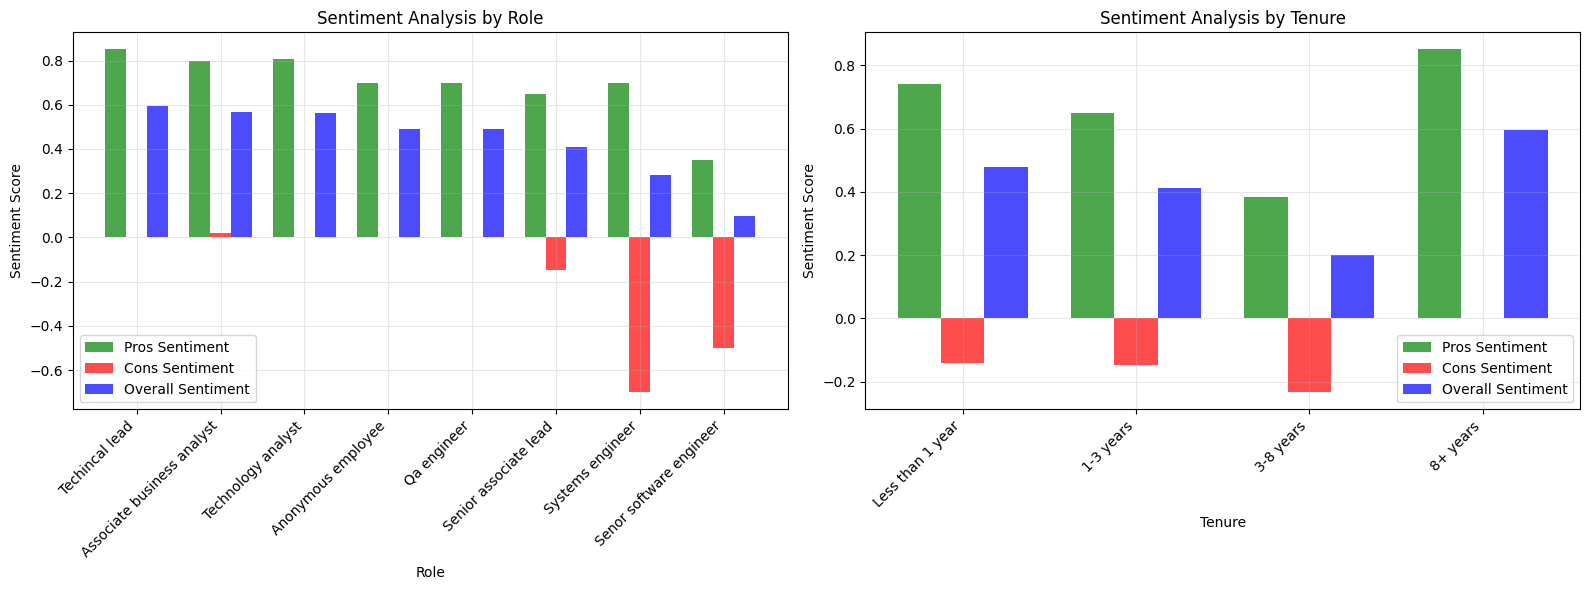

In [23]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Sentiment by role
roles_to_plot = role_sentiment[role_sentiment['review_count'] >= 1].index[:8]  # Top 8 roles
role_data = role_sentiment.loc[roles_to_plot]

x = np.arange(len(roles_to_plot))
width = 0.25

axes[0].bar(x - width, role_data['pros_sentiment'], width, label='Pros Sentiment', color='green', alpha=0.7)
axes[0].bar(x, role_data['cons_sentiment'], width, label='Cons Sentiment', color='red', alpha=0.7)
axes[0].bar(x + width, role_data['overall_sentiment'], width, label='Overall Sentiment', color='blue', alpha=0.7)

axes[0].set_xlabel('Role')
axes[0].set_ylabel('Sentiment Score')
axes[0].set_title('Sentiment Analysis by Role')
axes[0].set_xticks(x)
axes[0].set_xticklabels(roles_to_plot, rotation=45, ha='right')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Sentiment by tenure
tenure_order = ['Less than 1 year', '1-3 years', '3-8 years', '8+ years']
tenure_data = tenure_sentiment.reindex(tenure_order)

x_tenure = np.arange(len(tenure_order))
axes[1].bar(x_tenure - width, tenure_data['pros_sentiment'], width, label='Pros Sentiment', color='green', alpha=0.7)
axes[1].bar(x_tenure, tenure_data['cons_sentiment'], width, label='Cons Sentiment', color='red', alpha=0.7)
axes[1].bar(x_tenure + width, tenure_data['overall_sentiment'], width, label='Overall Sentiment', color='blue', alpha=0.7)

axes[1].set_xlabel('Tenure')
axes[1].set_ylabel('Sentiment Score')
axes[1].set_title('Sentiment Analysis by Tenure')
axes[1].set_xticks(x_tenure)
axes[1].set_xticklabels(tenure_order, rotation=45, ha='right')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

**Word Cloud for Pros and Cons**

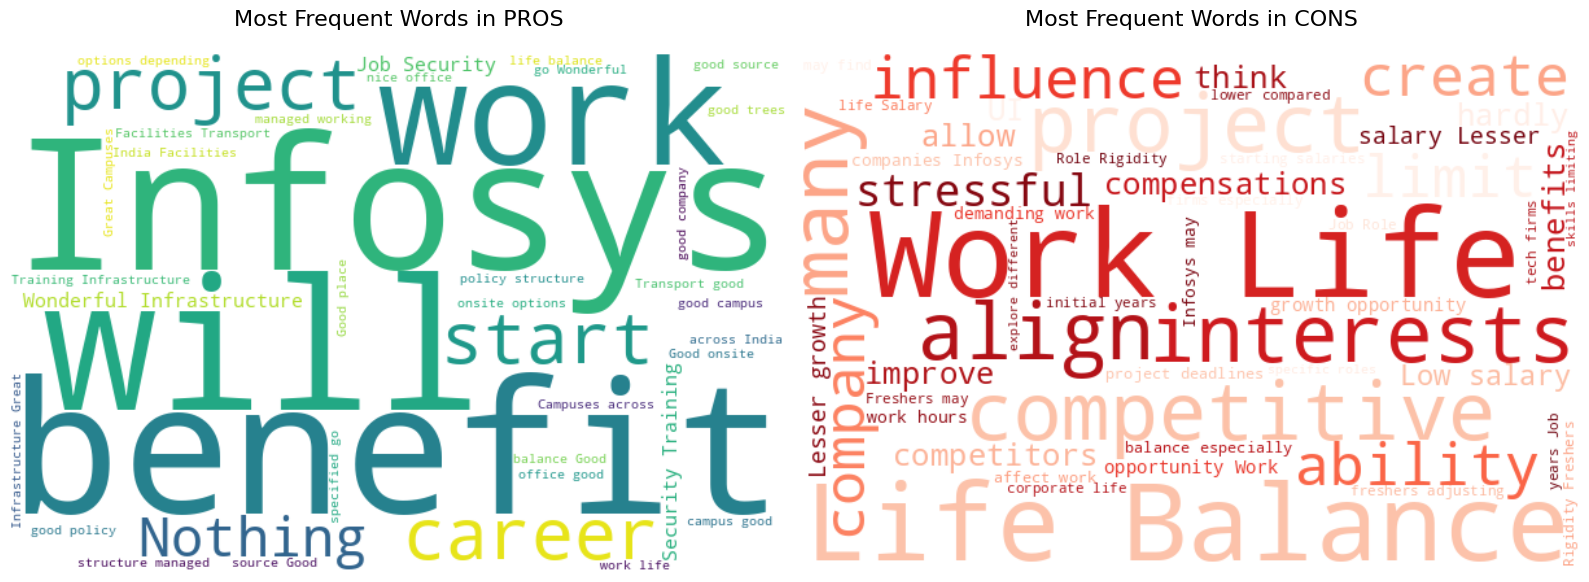

In [24]:
# Generate word clouds
all_pros_text = ' '.join(df['pros_clean'].dropna())
all_cons_text = ' '.join(df['cons_clean'].dropna())

# Create word clouds
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Pros word cloud
wordcloud_pros = WordCloud(width=600, height=400, background_color='white',
                          colormap='viridis', max_words=50).generate(all_pros_text)
axes[0].imshow(wordcloud_pros, interpolation='bilinear')
axes[0].set_title('Most Frequent Words in PROS', fontsize=16, pad=20)
axes[0].axis('off')

# Cons word cloud
wordcloud_cons = WordCloud(width=600, height=400, background_color='white',
                          colormap='Reds', max_words=50).generate(all_cons_text)
axes[1].imshow(wordcloud_cons, interpolation='bilinear')
axes[1].set_title('Most Frequent Words in CONS', fontsize=16, pad=20)
axes[1].axis('off')

plt.tight_layout()
plt.show()

**Extracting key Positive and Negative Phrases**

In [26]:
!pip install textblob wordcloud
!python -m textblob.download_corpora
import nltk
nltk.download('punkt')
nltk.download('brown')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data] Downloading package conll2000 to /root/nltk_data...
[nltk_data]   Unzipping corpora/conll2000.zip.
[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Unzipping corpora/movie_reviews.zip.
Finished.


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [27]:
# Function to extract key phrases
def extract_key_phrases(text_series, num_phrases=10):
    all_phrases = []
    for text in text_series:
        if text and len(str(text)) > 10:
            blob = TextBlob(str(text))
            all_phrases.extend([phrase for phrase in blob.noun_phrases if len(phrase) > 2])

    phrase_counts = Counter(all_phrases)
    return phrase_counts.most_common(num_phrases)

print("TOP POSITIVE PHRASES:")
top_pros_phrases = extract_key_phrases(df['pros_clean'])
for phrase, count in top_pros_phrases:
    print(f"  {phrase}: {count} mentions")

print("\nTOP NEGATIVE PHRASES:")
top_cons_phrases = extract_key_phrases(df['cons_clean'])
for phrase, count in top_cons_phrases:
    print(f"  {phrase}: {count} mentions")

TOP POSITIVE PHRASES:
  wonderful infrastructure: 30 mentions
  job: 30 mentions
  training: 30 mentions
  infrastructure: 30 mentions
  campuses: 30 mentions
  india: 30 mentions
  facilities: 30 mentions
  transport: 30 mentions
  good training good campus good trees: 30 mentions
  good policy structure: 30 mentions

TOP NEGATIVE PHRASES:
  lesser: 60 mentions
  work-life balance: 60 mentions
  infosys: 60 mentions
  low: 30 mentions
  growth opportunity: 30 mentions
  work hours: 30 mentions
  project deadlines: 30 mentions
  corporate life: 30 mentions
  tech firms: 30 mentions
  initial years: 30 mentions


**Executive Summary Analysis**

In [40]:
print("="*60)
print("EXECUTIVE SENTIMENT ANALYSIS SUMMARY")
print("="*60)

print(f"\nOVERVIEW:")
print(f"Total Reviews Analyzed: {len(df)}")
print(f"Average Numerical Rating: {df['rating'].mean():.2f}/5")
print(f"Average Overall Sentiment: {df['overall_sentiment'].mean():.3f}")

print(f"\nPOSITIVE FINDINGS:")
print(f"Pros Sentiment Score: {df['pros_sentiment'].mean():.3f} (Positive)")
print(f"Positive Pros Reviews: {(df['pros_sentiment'] > 0.1).sum()} ({(df['pros_sentiment'] > 0.1).sum()/len(df)*100:.1f}%)")

print(f"\nAREAS FOR IMPROVEMENT:")
print(f"Cons Sentiment Score: {df['cons_sentiment'].mean():.3f} (Negative)")
print(f"Negative Cons Reviews: {(df['cons_sentiment'] < -0.1).sum()} ({(df['cons_sentiment'] < -0.1).sum()/len(df)*100:.1f}%)")

print(f"\nKEY INSIGHTS:")
# Find most positive role
most_positive_role = role_sentiment.loc[role_sentiment['overall_sentiment'].idxmax()]
print(f"Most Satisfied Role: {role_sentiment['overall_sentiment'].idxmax()} (Sentiment: {most_positive_role['overall_sentiment']:.3f})")

# Find tenure with lowest sentiment
if not tenure_sentiment.empty:
    lowest_tenure_sentiment = tenure_sentiment.loc[tenure_sentiment['overall_sentiment'].idxmin()]
    print(f"Least Satisfied Tenure: {tenure_sentiment['overall_sentiment'].idxmin()} (Sentiment: {lowest_tenure_sentiment['overall_sentiment']:.3f})")

print(f"\nCORRELATION:")
print(f"Rating-Sentiment Correlation: {df['rating'].corr(df['overall_sentiment']):.3f}")

EXECUTIVE SENTIMENT ANALYSIS SUMMARY

OVERVIEW:
Total Reviews Analyzed: 300
Average Numerical Rating: 3.60/5
Average Overall Sentiment: 0.399

POSITIVE FINDINGS:
Pros Sentiment Score: 0.636 (Positive)
Positive Pros Reviews: 270 (90.0%)

AREAS FOR IMPROVEMENT:
Cons Sentiment Score: -0.154 (Negative)
Negative Cons Reviews: 120 (40.0%)

KEY INSIGHTS:
Most Satisfied Role: Techincal lead (Sentiment: 0.595)
Least Satisfied Tenure: 3-8 years (Sentiment: 0.199)

CORRELATION:
Rating-Sentiment Correlation: 0.652
